In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from joblib import dump

np.random.seed(123)
pd.set_option("display.precision", 3)


In [9]:
N = 300

# Typical ranges (illustrative)
CBR         = np.round(np.random.uniform(2, 20, size=N), 1)        # %
PI          = np.round(np.random.uniform(3, 25, size=N), 1)        # %
Moisture    = np.round(np.random.uniform(8, 25, size=N), 1)        # %
DryDensity  = np.round(np.random.uniform(1.5, 2.05, size=N), 3)    # g/cc
Fines_P75   = np.round(np.random.uniform(2, 25, size=N), 1)        # % passing 75 µm

# Simple OMC proxy (only for label logic / a feature)
OMC_est = (6 + 0.6*PI).round(1)

# Label rule (synthetic but civil-sensible):
# Suitable if: CBR ≥ 8 AND PI ≤ 12 AND Moisture ≤ OMC+2 AND Fines ≤ 12
label_bool = (CBR >= 8) & (PI <= 12) & (Moisture <= (OMC_est + 2)) & (Fines_P75 <= 12)
Label = np.where(label_bool, "Suitable", "NotSuitable")

df = pd.DataFrame({
    "CBR": CBR,
    "PI": PI,
    "Moisture": Moisture,
    "DryDensity": DryDensity,
    "Fines_P75": Fines_P75,
    "OMC_est": OMC_est,
    "Label": Label
})

print(df.head(10))
print("\nClass distribution:\n", df["Label"].value_counts())


    CBR    PI  Moisture  DryDensity  Fines_P75  OMC_est        Label
0  14.5   3.4      19.9       1.993       20.8      8.0  NotSuitable
1   7.2  18.9      20.0       1.623       13.6     17.3  NotSuitable
2   6.1   3.2      24.3       1.647       24.2      7.9  NotSuitable
3  11.9   4.9      22.9       1.607       17.1      8.9  NotSuitable
4  15.0   8.0      16.0       2.032       15.6     10.8  NotSuitable
5   9.6  22.3      18.6       1.562        7.3     19.4  NotSuitable
6  19.7  11.0      15.8       1.897       18.5     12.6  NotSuitable
7  14.3  14.9      11.8       2.013        8.6     14.9  NotSuitable
8  10.7  15.5      14.4       1.867       21.5     15.3  NotSuitable
9   9.1   8.0       9.8       1.972       24.5     10.8  NotSuitable

Class distribution:
 Label
NotSuitable    291
Suitable         9
Name: count, dtype: int64


In [10]:
X = df[["CBR","PI","Moisture","DryDensity","Fines_P75","OMC_est"]]
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train class balance:\n", y_train.value_counts(normalize=True).round(3))


Train shape: (225, 6)  Test shape: (75, 6)
Train class balance:
 Label
NotSuitable    0.969
Suitable       0.031
Name: proportion, dtype: float64


In [11]:
tree = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=4,
    min_samples_leaf=8,
    random_state=42
)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted", zero_division=0)

print(f"DecisionTree baseline -> Acc: {acc:.3f}  Prec: {prec:.3f}  Rec: {rec:.3f}  F1: {f1:.3f}")
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred, labels=["Suitable","NotSuitable"])
cm_df = pd.DataFrame(cm, index=["True:Suitable","True:NotSuitable"], columns=["Pred:Suitable","Pred:NotSuitable"])
print("\nConfusion matrix:\n", cm_df)


DecisionTree baseline -> Acc: 0.973  Prec: 0.947  Rec: 0.973  F1: 0.960

Classification report:
               precision    recall  f1-score   support

 NotSuitable       0.97      1.00      0.99        73
    Suitable       0.00      0.00      0.00         2

    accuracy                           0.97        75
   macro avg       0.49      0.50      0.49        75
weighted avg       0.95      0.97      0.96        75


Confusion matrix:
                   Pred:Suitable  Pred:NotSuitable
True:Suitable                 0                 2
True:NotSuitable              0                73


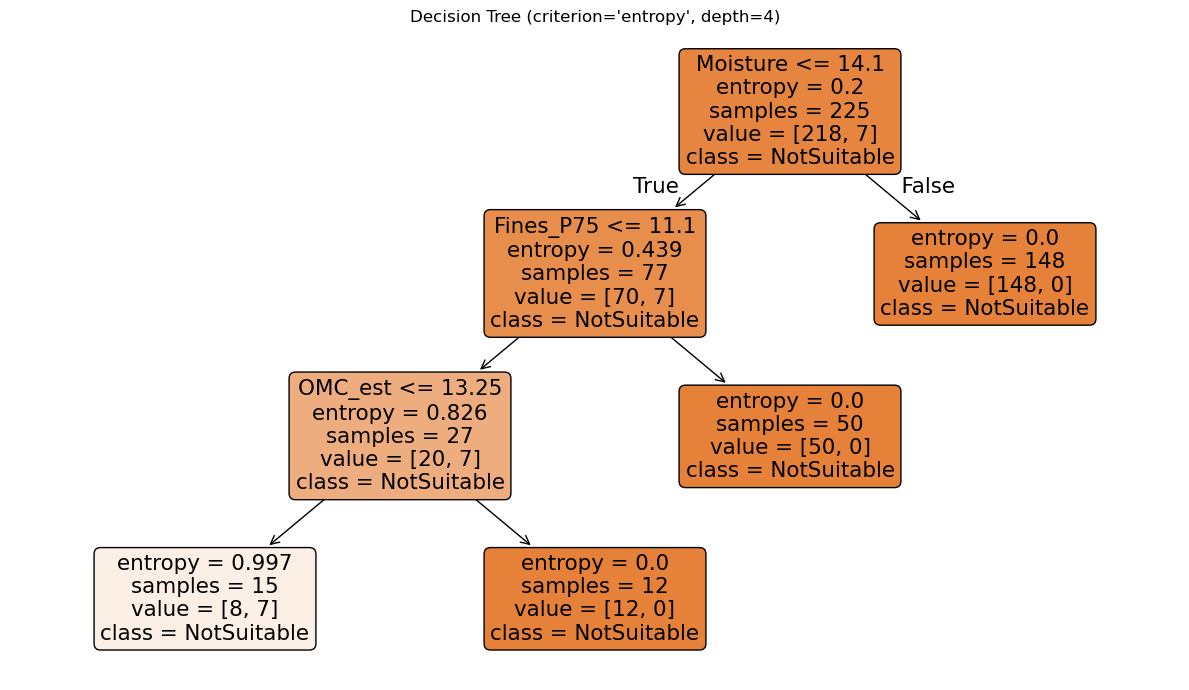

In [12]:
plt.figure(figsize=(12,7))
plot_tree(
    tree,
    feature_names=X.columns,
    class_names=tree.classes_,
    filled=True,
    rounded=True,
    max_depth=4
)
plt.title("Decision Tree (criterion='entropy', depth=4)")
plt.tight_layout(); plt.show()


In [13]:
param_grid = {
    "criterion": ["entropy", "gini"],
    "max_depth": [3, 4, 5, None],
    "min_samples_leaf": [3, 5, 8, 12]
}
dt = DecisionTreeClassifier(random_state=42)

gcv_dt = GridSearchCV(
    dt, param_grid, scoring="accuracy", cv=5, n_jobs=-1, refit=True
)
gcv_dt.fit(X_train, y_train)

best_tree = gcv_dt.best_estimator_
print("Best DT params:", gcv_dt.best_params_)

y_pred_best = best_tree.predict(X_test)
acc = accuracy_score(y_test, y_pred_best)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_best, average="weighted", zero_division=0)
print(f"Best DT -> Acc: {acc:.3f}  Prec: {prec:.3f}  Rec: {rec:.3f}  F1: {f1:.3f}")


Best DT params: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3}
Best DT -> Acc: 0.960  Prec: 0.969  Rec: 0.960  F1: 0.964


In [14]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_grid = {
    "n_estimators": [150, 300],
    "max_depth": [None, 5, 8],
    "min_samples_leaf": [1, 3, 5]
}
gcv_rf = GridSearchCV(
    rf, rf_grid, scoring="accuracy", cv=5, n_jobs=-1, refit=True
)
gcv_rf.fit(X_train, y_train)

rf_best = gcv_rf.best_estimator_
print("Best RF params:", gcv_rf.best_params_)

y_pred_rf = rf_best.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf, rec_rf, f1_rf, _ = precision_recall_fscore_support(y_test, y_pred_rf, average="weighted", zero_division=0)
print(f"Best RF -> Acc: {acc_rf:.3f}  Prec: {prec_rf:.3f}  Rec: {rec_rf:.3f}  F1: {f1_rf:.3f}")

# Feature importances (RF)
imp = pd.Series(rf_best.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nRandom Forest feature importance:\n", imp.round(3))


Best RF params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 150}
Best RF -> Acc: 0.973  Prec: 0.947  Rec: 0.973  F1: 0.960

Random Forest feature importance:
 Moisture      0.294
Fines_P75     0.271
OMC_est       0.165
PI            0.139
CBR           0.067
DryDensity    0.064
dtype: float64


In [15]:
# Pick one held-out sample
sample = X_test.iloc[[0]]
pred = best_tree.predict(sample)[0]
proba = best_tree.predict_proba(sample)[0]

print("Sample features:\n", sample)
print("\nBest DT prediction:", pred, "  Probabilities:", dict(zip(best_tree.classes_, proba.round(3))))

# Walk the path without relying on private sklearn APIs
node_indicator = best_tree.decision_path(sample).toarray()[0]
node_index = np.where(node_indicator == 1)[0]

tree_ = best_tree.tree_
feature = tree_.feature       # index per node (=-2 at leaves)
threshold = tree_.threshold

print("\nDecision path (Best DT):")
for node_id in node_index:
    if feature[node_id] != -2:  # -2 is TREE_UNDEFINED for leaves
        fname = X.columns[feature[node_id]]
        thr = threshold[node_id]
        val = sample.iloc[0, feature[node_id]]
        direction = "<=" if val <= thr else ">"
        print(f"  if {fname} {direction} {thr:.3f} (value={val})")
    else:
        print("  -> reached leaf")


Sample features:
       CBR    PI  Moisture  DryDensity  Fines_P75  OMC_est
139  11.9  12.7      16.9        1.63       22.4     13.6

Best DT prediction: NotSuitable   Probabilities: {'NotSuitable': np.float64(1.0), 'Suitable': np.float64(0.0)}

Decision path (Best DT):
  if Moisture > 11.550 (value=16.9)
  if DryDensity > 1.518 (value=1.63)
  -> reached leaf


In [16]:
dump(best_tree, "best_decision_tree_subgrade.joblib")
dump(rf_best,   "best_random_forest_subgrade.joblib")
print("Saved: best_decision_tree_subgrade.joblib, best_random_forest_subgrade.joblib")


Saved: best_decision_tree_subgrade.joblib, best_random_forest_subgrade.joblib
